In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, f1_score, confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report , confusion_matrix
import cv2
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense , Flatten , Dropout , Conv2D , MaxPooling2D
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)
# https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification

Mounted at /content/drive/


In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Disable verbose logging
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

In [28]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_gen = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/PLP Resources/archive (8)/garbage classification/Garbage classification',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training')

val_gen = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/PLP Resources/archive (8)/garbage classification/Garbage classification',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation')

Found 2025 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(6, activation='softmax')  # 6 classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_gen, validation_data=val_gen, epochs=10)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 565s 9s/step - accuracy: 0.4785 - loss: 1.3378 - val_accuracy: 0.6581 - val_loss: 0.9015
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7690 - loss: 0.6547 - val_accuracy: 0.7097 - val_loss: 0.7582
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8032 - loss: 0.5494 - val_accuracy: 0.6998 - val_loss: 0.7551
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.8438 - loss: 0.4392 - val_accuracy: 0.7217 - val_loss: 0.7204
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8598 - loss: 0.4323 - val_accuracy: 0.7356 - val_loss: 0.6817
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8687 - loss: 0.3651 - val_accuracy: 0.7455 - val_loss: 0.6496
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8930 - loss: 0.3227 - val_accuracy: 0.7336 - val_loss: 0.6878
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0

In [ ]:
val_preds = model.predict(val_gen)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_gen.classes

print(classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))

16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
              precision    recall  f1-score   support

   cardboard       0.17      0.12      0.14        80
       glass       0.19      0.19      0.19       100
       metal       0.14      0.15      0.14        82
       paper       0.20      0.24      0.22       118
     plastic       0.23      0.24      0.24        96
       trash       0.00      0.00      0.00        27

    accuracy                           0.18       503
   macro avg       0.16      0.16      0.16       503
weighted avg       0.18      0.18      0.18       503



In [ ]:
# Save model
model.save('/content/drive/MyDrive/PLP Resources/recyclenet_model.keras')

saved_model = tf.keras.models.load_model('/content/drive/MyDrive/PLP Resources/recyclenet_model.keras')

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(saved_model)
tflite_model = converter.convert()

# Save TFLite model
with open('/content/drive/MyDrive/PLP Resources/recyclenet_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpt6co9iho'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136994080194384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136994080193616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136994080190736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136994080191120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136994080194192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136994080192272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136994080188816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136994080188432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136994080188624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136994080179024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1369940801872

In [ ]:
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/PLP Resources/recyclenet_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess one test image
import cv2
img = cv2.imread('/content/drive/MyDrive/PLP Resources/archive (8)/garbage classification/Garbage classification/plastic/plastic1.jpg')
img = cv2.resize(img, IMG_SIZE)
input_data = np.expand_dims(img / 255.0, axis=0).astype(np.float32)

# Run inference
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

output = interpreter.get_tensor(output_details[0]['index'])
print("Predicted Class:", val_gen.class_indices.keys().__iter__().__next__(), np.argmax(output))

Predicted Class: cardboard 1


In [ ]:
X_train = []
y_train = []
labels = ["cardboard" , "glass" , "metal" , "paper" , "plastic" , "trash"]
image_size = 224

for label in labels :
    folderPath = os.path.join("/content/drive/MyDrive/PLP Resources/archive (8)/garbage classification/Garbage classification/" , label)
    for path in os.listdir(folderPath) :
        image_path = os.path.join(folderPath , path)
        image = cv2.imread(image_path)
        image = cv2.resize(image , (image_size , image_size))
        X_train.append(image)
        y_train.append(label)

In [ ]:
X_test = []
y_test = []

for label in labels :
    folderPath = os.path.join("/content/drive/MyDrive/PLP Resources/archive (8)/garbage classification/Garbage classification/" , label)
    for path in os.listdir(folderPath) :
        image_path = os.path.join(folderPath , path)
        image = cv2.imread(image_path)
        image = cv2.resize(image , (image_size , image_size))
        X_test.append(image)
        y_test.append(label)

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
X_train , y_train = shuffle(X_train , y_train , random_state = 42)

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
y_train = to_categorical(y_train , num_classes = 6)
y_test = to_categorical(y_test , num_classes = 6)

In [ ]:
print(f" X_train : {X_train.shape} ")
print(f" X_test : {X_test.shape} ")
print(f" y_train : {y_train.shape} ")
print(f" y_test : {y_test.shape} ")

 X_train : (2528, 224, 224, 3) 
 X_test : (2528, 224, 224, 3) 
 y_train : (2528, 6) 
 y_test : (2528, 6) 


In [ ]:
datagen = ImageDataGenerator(validation_split = 0.2 ,
                             rescale = 1.0/255.00 ,
                             horizontal_flip = True ,
                             width_shift_range = 0.2 ,
                             height_shift_range = 0.2 ,
                             zoom_range = 90)

In [ ]:
datagen.fit(X_train)

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 16 , kernel_size = (3,3) , input_shape = (224,224,3) ,
                padding = "same" , activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 32 , kernel_size = (3,3) , activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2) , strides = (2,2)))

learning_rate = 0.001
optimizer = Adam(learning_rate = learning_rate)

model.add(Flatten())
model.add(Dense(512 , activation = "relu"))
model.add(Dense(6 , activation = "softmax"))

model.compile(optimizer = optimizer ,loss = "categorical_crossentropy" , metrics = ["accuracy"])

In [ ]:
early_stopping = EarlyStopping(monitor = "val_loss" , patience = 10 , restore_best_weights = True , verbose = 1 )

In [14]:
history = model.fit(X_train , y_train , epochs = 60 , batch_size = 64 , verbose = 1 ,
                   validation_data = (X_test , y_test) , callbacks = early_stopping)

Epoch 1/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 195s 5s/step - accuracy: 0.1963 - loss: 7854.8965 - val_accuracy: 0.2140 - val_loss: 1.7844
Epoch 2/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 195s 5s/step - accuracy: 0.2148 - loss: 1.9453 - val_accuracy: 0.2366 - val_loss: 1.7632
Epoch 3/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - accuracy: 0.2758 - loss: 1.7056 - val_accuracy: 0.2520 - val_loss: 1.7265
Epoch 4/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.3256 - loss: 1.6254 - val_accuracy: 0.2773 - val_loss: 1.6829
Epoch 5/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 192s 5s/step - accuracy: 0.3516 - loss: 1.5586 - val_accuracy: 0.3228 - val_loss: 1.5966
Epoch 6/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - accuracy: 0.3820 - loss: 1.4733 - val_accuracy: 0.3845 - val_loss: 1.4637
Epoch 7/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 190s 5s/step - accuracy: 0.4365 - loss: 1.3588 - val_accuracy: 0.4023 - val_loss: 1.4356
Epoch 8/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.4865 - loss: 1.2737 - val_accuracy: 0.4537 

In [15]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred , axis = 1)
y_test = np.argmax(y_test , axis = 1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 465ms/step


In [16]:
labels = ["cardboard" , "glass" , "metal" , "paper" , "plastic" , "trash"]

In [17]:
print(classification_report(y_pred , y_test , target_names = labels))

              precision    recall  f1-score   support

   cardboard       0.84      0.99      0.91       342
       glass       0.82      0.98      0.90       420
       metal       0.95      1.00      0.98       392
       paper       0.79      0.97      0.87       484
     plastic       0.99      0.61      0.76       782
       trash       0.78      1.00      0.88       108

    accuracy                           0.87      2528
   macro avg       0.86      0.93      0.88      2528
weighted avg       0.89      0.87      0.86      2528



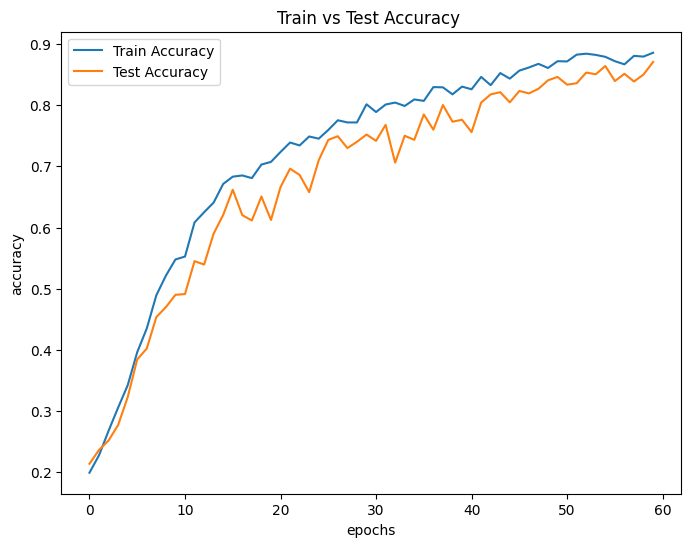

In [18]:
plt.figure(figsize = (8,6))
sns.lineplot(history.history["accuracy"] , label = "Train Accuracy")
sns.lineplot(history.history["val_accuracy"] , label = "Test Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Train vs Test Accuracy ")
plt.legend()
plt.show()

In [19]:
cm = confusion_matrix(y_pred , y_test)
cm_df = pd.DataFrame(cm, index = labels , columns = labels)

<Axes: >

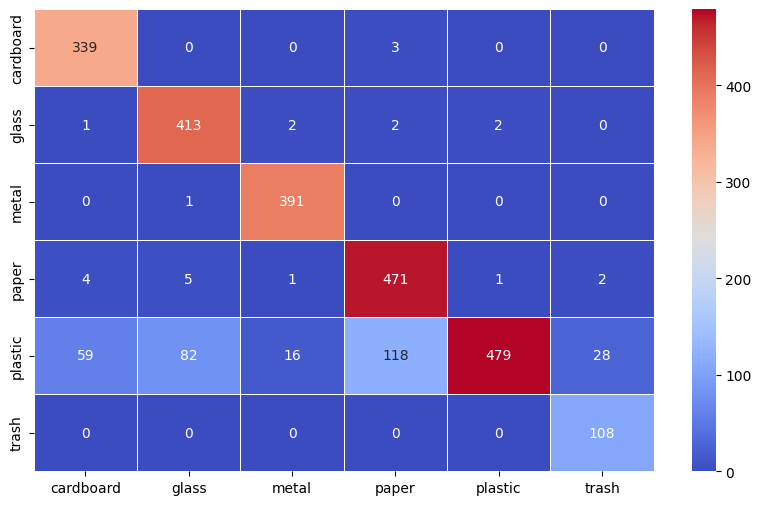

In [20]:
plt.figure(figsize = (10,6))
sns.heatmap(cm_df , annot = True ,
            fmt = "d" , linewidths = 0.5 , cmap = "coolwarm")

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 110, 110, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 96800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    49,562,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,710,836 (567.29 MB)

 Trainable params: 49,570,278 (189.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,140,558 (378.19 MB)

In [22]:
# Save model
model.save('/content/drive/MyDrive/PLP Resources/recyclenet_model.keras')

saved_model = tf.keras.models.load_model('/content/drive/MyDrive/PLP Resources/recyclenet_model.keras')

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(saved_model)
tflite_model = converter.convert()

# Save TFLite model
with open('/content/drive/MyDrive/PLP Resources/recyclenet_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpmkpjwdkz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136728453235920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728453237456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728453236688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728453238608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728453238032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728453239376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728453238800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728453240144: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [27]:
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/PLP Resources/recyclenet_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

IMG_SIZE = (224, 224)

# Load and preprocess one test image
import cv2
img = cv2.imread('/content/drive/MyDrive/PLP Resources/archive (8)/garbage classification/Garbage classification/plastic/plastic1.jpg')
img = cv2.resize(img, IMG_SIZE)
input_data = np.expand_dims(img / 255.0, axis=0).astype(np.float32)

# Run inference
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

output = interpreter.get_tensor(output_details[0]['index'])
predicted_class_index = np.argmax(output)
predicted_class_name = labels[predicted_class_index]
print("Predicted Class:", predicted_class_name)

Predicted Class: plastic


In [25]:
print(output)

[[0.06602293 0.17448701 0.14673327 0.18042342 0.33184227 0.10049099]]


In [29]:
print("Predicted Class:", val_gen.class_indices.keys().__iter__().__next__(), np.argmax(output))

Predicted Class: cardboard 4
